
How does this VAE work?

Using convolutional layers, the images are compressed or reduced in dimensionality. In this exercise the encoder uses four convolutional layers to reduce the input dimensions from 32x32 to 4x4 while capturing the features of the inputs in the 4th dimension, the NUM_DIMENSIONS.

The encoder maps the pixel data in the images to a more generalized latent space. Each image or batch of images is reduced to a mean and variance vector outputted by the encoder. The sampling layer then randomly selects a vector from a normal gaussian distribution (epsilon), then the vector is scaled and shifted according to the mean and variance vectors learned by the encoder.

The key here is that the encoder and decoder are probabilstic. The encoder is responsible for modeling the conditional probability distribution P(z|x), as it takes an input image x and produces a latent representation z.

The process of generating new samples involves sampling random points from the learned latent space distribution and decoding them into images. Since the VAE learns a probabilistic distribution of the data, different points in the latent space correspond to different variations of the input data. By sampling from this distribution, the model can generate diverse outputs, effectively extrapolating from the training data to create new, unseen samples.

Orignally from https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_faces.ipynb

by David Foster



In [78]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd
import os

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000 # This parameter requires tuning for the dataset
LOAD_MODEL = False

In [65]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/Volumes/xenon/datasets/celebA/celeba-dataset",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [66]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))

2024-04-07 10:53:36.158960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 822 of 1024
2024-04-07 10:53:38.584520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


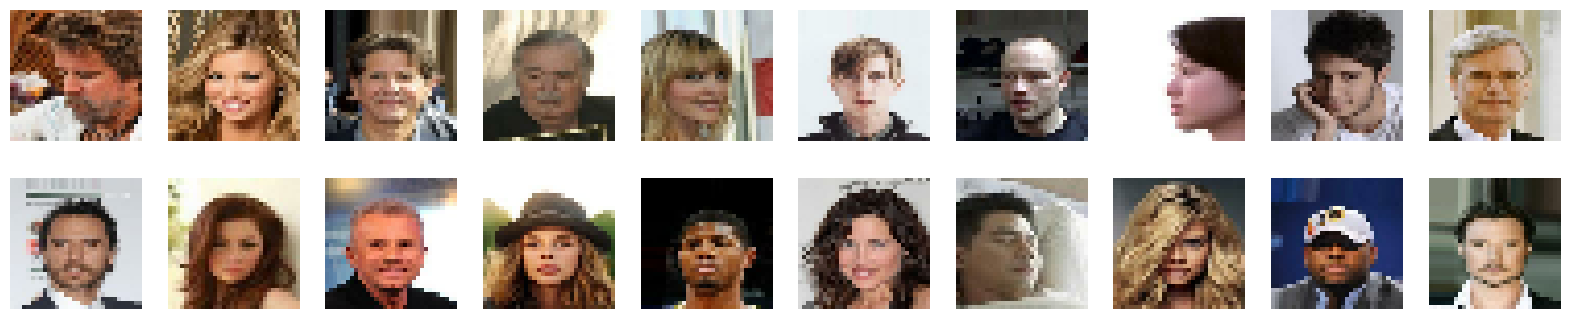

In [67]:
# Display some images from the first batch of the dataset

for images in train.take(1):
    plt.figure(figsize=(20, 4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

In [68]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Compute the latent space vectors (z) by adding the mean (z_mean) to the product of the standard deviation (square root of the variance) and the random noise (epsilon).
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [69]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 16, 16, 128)          3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_22 (Ba  (None, 16, 16, 128)          512       ['conv2d_12[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_22 (LeakyReLU)  (None, 16, 16, 128)          0         ['batch_normalization_22

In [70]:
# Decoder

decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)    

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)   

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)   

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)   

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense_2 (Dense)             (None, 512)               102912    
                                                                 
 batch_normalization_26 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 512)               0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 2, 128)         0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 4, 4, 128)         147584    
 DTranspose)                                               

In [71]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [72]:
# Crate the VAE
vae = VAE(encoder, decoder)

In [73]:
# Compile the VAE
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [74]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./vae_faces/logs")

In [79]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        output_dir = "./vae_faces/output/"
        os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./vae_faces/output/generated_img_%03d_%d.png" % (epoch, i))

In [76]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./vae_faces/models/vae")
    tmp = vae.predict(train.take(1))

In [80]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10


2024-04-07 18:17:22.308094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 236 of 1024
2024-04-07 18:17:41.515771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 68.3498 - reconstruction_loss: 51.1885 - kl_loss: 16.3494WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 3630s 2s/step - loss: 68.3493 - reconstruction_loss: 51.1885 - kl_loss: 16.3494
Epoch 2/10


2024-04-07 19:17:52.688633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 523 of 1024
2024-04-07 19:18:02.726345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 940 of 1024
2024-04-07 19:18:04.664686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 66.1264 - reconstruction_loss: 49.1078 - kl_loss: 16.7344WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 3357s 2s/step - loss: 66.1263 - reconstruction_loss: 49.1078 - kl_loss: 16.7344
Epoch 3/10


2024-04-07 20:13:50.272646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 307 of 1024
2024-04-07 20:14:00.398786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 692 of 1024
2024-04-07 20:14:12.400932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 65.3094 - reconstruction_loss: 48.3329 - kl_loss: 16.8219WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 3021s 2s/step - loss: 65.3093 - reconstruction_loss: 48.3329 - kl_loss: 16.8219
Epoch 4/10


2024-04-07 21:04:11.014953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 571 of 1024
2024-04-07 21:04:16.841736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 64.9362 - reconstruction_loss: 47.7894 - kl_loss: 16.9954WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 2876s 2s/step - loss: 64.9361 - reconstruction_loss: 47.7894 - kl_loss: 16.9954
Epoch 5/10


2024-04-07 21:52:06.611730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 683 of 1024
2024-04-07 21:52:10.913445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 64.5177 - reconstruction_loss: 47.1435 - kl_loss: 17.2175WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 3013s 2s/step - loss: 64.5176 - reconstruction_loss: 47.1435 - kl_loss: 17.2175
Epoch 6/10


2024-04-07 22:42:19.592318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 758 of 1024
2024-04-07 22:42:25.569770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 64.1647 - reconstruction_loss: 46.7314 - kl_loss: 17.3378WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 3443s 2s/step - loss: 64.1646 - reconstruction_loss: 46.7314 - kl_loss: 17.3378
Epoch 7/10


2024-04-07 23:39:42.322910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 660 of 1024
2024-04-07 23:39:50.639186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 63.9723 - reconstruction_loss: 46.4222 - kl_loss: 17.4322WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 3048s 2s/step - loss: 63.9723 - reconstruction_loss: 46.4222 - kl_loss: 17.4322
Epoch 8/10


2024-04-08 00:30:30.414955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 730 of 1024
2024-04-08 00:30:36.094777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 63.7212 - reconstruction_loss: 46.0687 - kl_loss: 17.5471WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 3453s 2s/step - loss: 63.7212 - reconstruction_loss: 46.0687 - kl_loss: 17.5471
Epoch 9/10


2024-04-08 01:28:03.685755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 756 of 1024
2024-04-08 01:28:09.263354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 63.5327 - reconstruction_loss: 45.8194 - kl_loss: 17.6185WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 2976s 2s/step - loss: 63.5327 - reconstruction_loss: 45.8194 - kl_loss: 17.6185
Epoch 10/10


2024-04-08 02:17:39.332251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 695 of 1024
2024-04-08 02:17:43.494217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - ETA: 0s - loss: 63.3616 - reconstruction_loss: 45.6131 - kl_loss: 17.6688WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 3463s 2s/step - loss: 63.3615 - reconstruction_loss: 45.6131 - kl_loss: 17.6688


In [81]:
# Save the final models
vae.save("./vae_faces/models/vae")
encoder.save("./vae_faces/models/encoder")
decoder.save("./vae_faces/models/decoder")

INFO:tensorflow:Assets written to: ./vae_faces/models/vae/assets


INFO:tensorflow:Assets written to: ./vae_faces/models/vae/assets


INFO:tensorflow:Assets written to: ./vae_faces/models/encoder/assets


INFO:tensorflow:Assets written to: ./vae_faces/models/encoder/assets


INFO:tensorflow:Assets written to: ./vae_faces/models/decoder/assets


INFO:tensorflow:Assets written to: ./vae_faces/models/decoder/assets


In [93]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

2024-04-08 06:05:19.634549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 775 of 1024
2024-04-08 06:05:22.898657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


In [95]:
example_images.shape

(128, 32, 32, 3)

In [105]:
def display_images(images):
    num_images = len(images)
    rows = (num_images + 9) // 10  # Calculate number of rows needed
    plt.figure(figsize=(20, 20))  # Set figure size based on number of rows
    
    for i in range(20):
        plt.subplot(rows, 10, i + 1)  # Subplot index starts from 1
        plt.imshow(images[i])
        plt.axis("off")
        
    plt.show()

4/4 [==============================] - 0s 106ms/step
Actual Images


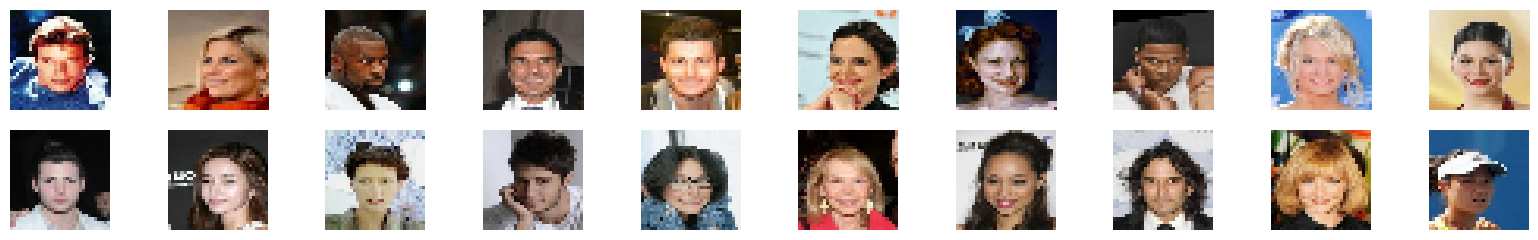

Reconstructions


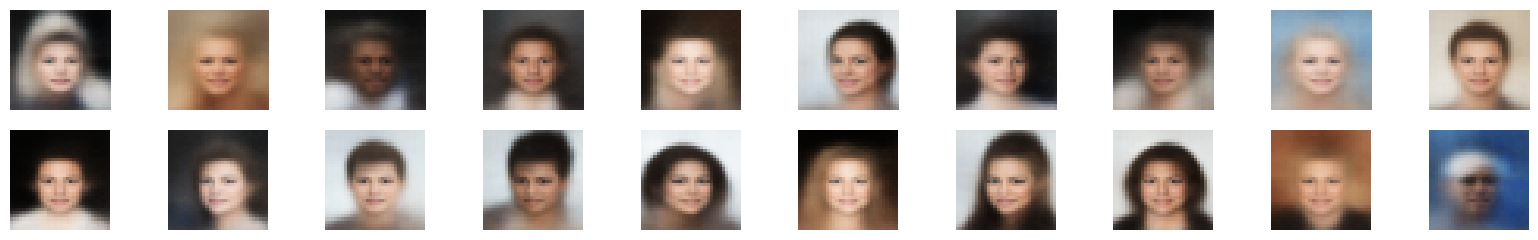

In [106]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Actual Images")
display_images(example_images)
print("Reconstructions")
display_images(reconstructions)

4/4 [==============================] - 1s 40ms/step


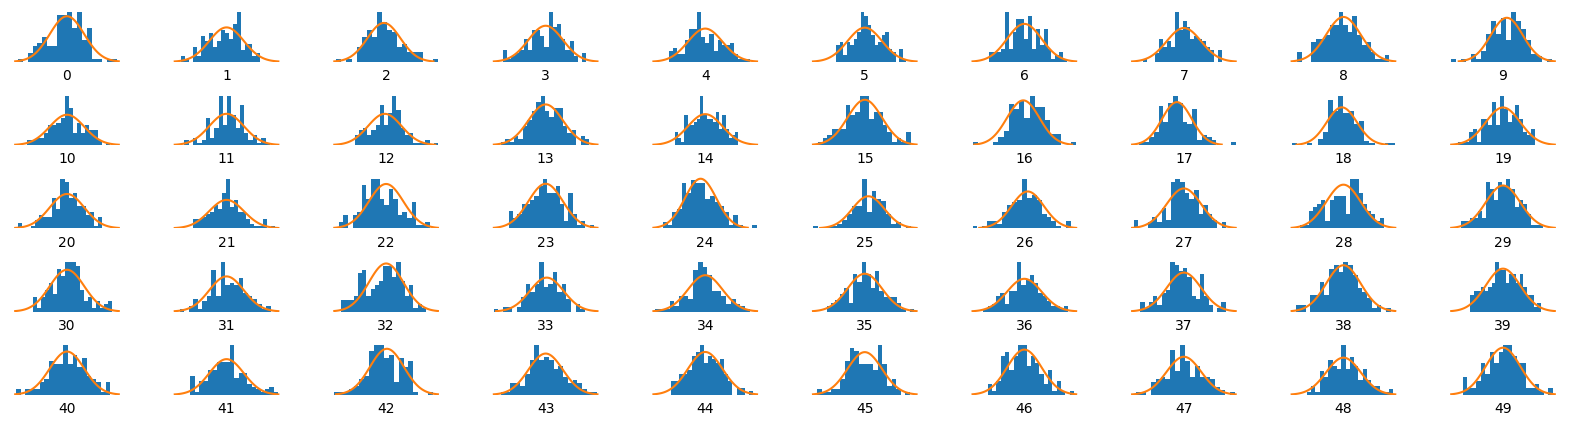

In [88]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

In [107]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

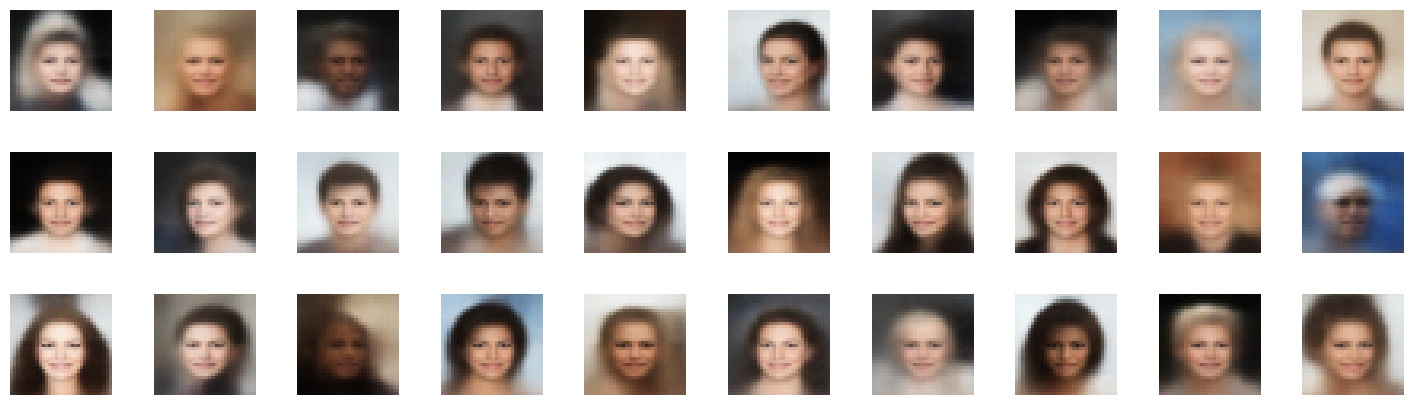

In [108]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])